# Treinando RandomForest

In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
import csv
import unidecode 
import pandas.core.algorithms as algos
from scipy.stats import kendalltau   
from funcoes_uteis import *
from dateutil.relativedelta import relativedelta

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def diff_month(d1, d2):
    return (d1.year - d2.year)*12 + d1.month - d2.month

def periodicidade(x):
    if x == 'Trienal':
        return 36    
    elif x == 'Anual':
        return 12
    elif x == 'Semestral':
        return 6
    elif x == 'Trimestral':
        return 3
    else: 
        return 1

def marca_base(Perc, x):
    if x >= Perc[(len(Perc)-1)]:
        return len(Perc) +1
    else:
        for i in range(len(Perc)):
            if x < Perc[i]:
                return i + 1


def cria_curva(percentiles, variavel):
    Perc = list()
    for i in range(len(percentiles)):
        Perc.append(np.percentile(variavel, percentiles[i]))
    return Perc    
    


In [3]:
def ArrumaBase_Consumo(fim_janela_feature, janela_booking, df_base):
    aux_janela_feature = fim_janela_feature+ relativedelta(months=-12)
    inicio_janela_booking = fim_janela_feature
    fim_janela_booking = fim_janela_feature+ relativedelta(months=janela_booking)
    df_treino = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature)].copy()
    grade = pd.date_range(start=aux_janela_feature, end=df_treino.Instalacao_AnoMes.max(), freq='MS', normalize=True)
    agg_dict = {'nr_PrecoMensal' : 'sum'}
    df_historico_valor = df_treino[(df_treino.nr_PrecoMensal> 0) & (df_treino.Instalacao_AnoMes >= aux_janela_feature)].groupby(['cd_ChaveCliente', 'Instalacao_AnoMes']).agg(agg_dict)
    novo_indice = [(x, y) for x in df_historico_valor.index.levels[0] for y in grade]
    novo_indice = pd.MultiIndex.from_tuples(novo_indice, names=df_historico_valor.index.names)
    df_historico_valor = df_historico_valor.reindex(novo_indice, fill_value=0)
    df_historico_valor = df_historico_valor.unstack(level=-1)
    df_historico_valor.columns = df_historico_valor.columns.droplevel()
    colunas = ['vlr_m-1','vlr_m-2','vlr_m-3','vlr_m-4','vlr_m-5','vlr_m-6','vlr_m-7','vlr_m-8','vlr_m-9','vlr_m-10','vlr_m-11','vlr_m-12'] 
    df_historico_valor.columns = colunas
    df_historico_valor['vlr_trim-1'] = [v1+v2+v3 for v1,v2,v3 in zip
                                        (df_historico_valor['vlr_m-1'], 
                                         df_historico_valor['vlr_m-2'],  
                                         df_historico_valor['vlr_m-3'])]
    df_historico_valor['vlr_trim-2'] = [v1+v2+v3 for v1,v2,v3 in zip
                                        (df_historico_valor['vlr_m-4'], 
                                         df_historico_valor['vlr_m-5'],  
                                         df_historico_valor['vlr_m-6'])]
    df_historico_valor['vlr_trim-3'] = [v1+v2+v3 for v1,v2,v3 in zip
                                        (df_historico_valor['vlr_m-7'], 
                                         df_historico_valor['vlr_m-8'],  
                                         df_historico_valor['vlr_m-9'])]
    df_historico_valor['vlr_trim-4'] = [v1+v2+v3 for v1,v2,v3 in zip
                                        (df_historico_valor['vlr_m-10'], 
                                         df_historico_valor['vlr_m-11'],  
                                         df_historico_valor['vlr_m-12'])]
    df_historico_valor['vlr_ano'] = [v1+v2+v3+v4 for v1,v2,v3,v4 in zip
                                        (df_historico_valor['vlr_trim-1'], 
                                         df_historico_valor['vlr_trim-2'],  
                                         df_historico_valor['vlr_trim-3'],
                                         df_historico_valor['vlr_trim-4'])]
    agg_dict = {'Provisioning' : 'count'}
    df_historico_qtd = df_treino[df_treino.Instalacao_AnoMes >= aux_janela_feature].groupby(['cd_ChaveCliente', 'Instalacao_AnoMes']).agg(agg_dict)
    novo_indice = [(x, y) for x in df_historico_qtd.index.levels[0] for y in grade]
    novo_indice = pd.MultiIndex.from_tuples(novo_indice, names=df_historico_qtd.index.names)
    df_historico_qtd = df_historico_qtd.reindex(novo_indice, fill_value=0)
    df_historico_qtd = df_historico_qtd.unstack(level=-1)
    df_historico_qtd.columns = df_historico_qtd.columns.droplevel()
    colunas_ts = [c for c in df_historico_qtd.columns if isinstance(c, pd.tslib.Timestamp)]
    colunas = ['qtd_m-1','qtd_m-2','qtd_m-3','qtd_m-4','qtd_m-5','qtd_m-6',
               'qtd_m-7','qtd_m-8','qtd_m-9','qtd_m-10','qtd_m-11','qtd_m-12'] 
    df_historico_qtd.columns = colunas
    df_historico_qtd['qtd_trim-1'] = [q1+q2+q3 for q1,q2,q3 in zip
                                      (df_historico_qtd['qtd_m-1'],
                                       df_historico_qtd['qtd_m-2'],
                                       df_historico_qtd['qtd_m-3'])]
    df_historico_qtd['qtd_trim-2'] = [q1+q2+q3 for q1,q2,q3 in zip
                                      (df_historico_qtd['qtd_m-4'], 
                                       df_historico_qtd['qtd_m-5'],  
                                       df_historico_qtd['qtd_m-6'])]
    df_historico_qtd['qtd_trim-3'] = [q1+q2+q3 for q1,q2,q3 in zip
                                      (df_historico_qtd['qtd_m-7'], 
                                       df_historico_qtd['qtd_m-8'],  
                                       df_historico_qtd['qtd_m-9'])]
    df_historico_qtd['qtd_trim-4'] = [q1+q2+q3 for q1,q2,q3 in zip
                                      (df_historico_qtd['qtd_m-10'], 
                                       df_historico_qtd['qtd_m-11'],  
                                       df_historico_qtd['qtd_m-12'])]
    df_historico_qtd['qtd_ano'] = [v1+v2+v3+v4 for v1,v2,v3,v4 in zip
                                   (df_historico_qtd['qtd_trim-1'], 
                                    df_historico_qtd['qtd_trim-2'],  
                                    df_historico_qtd['qtd_trim-3'],
                                    df_historico_qtd['qtd_trim-4'])]
    df_historico = pd.concat([df_historico_valor, df_historico_qtd], axis=1)
    df_treino['Periodicidade_Meses'] = [periodicidade(x) for x in df_treino.ds_Periodicidade]
    df_treino['idade_prov'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Instalacao_AnoMes]
    df_treino['idade_cli'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Primeiro_Servico_LW_AnoMes]
    df_treino['quantidade_renovacoes_prov'] = [int(id_prov/peri_mes) for 
                                               id_prov, peri_mes in zip (df_treino.idade_prov, df_treino.Periodicidade_Meses)]
    df_treino['Qtd_meses_P_renovacoes'] = [peri_mes-(idade_prov-qtd_renov*peri_mes) for
                                           peri_mes,idade_prov,qtd_renov in 
                                           zip(df_treino.Periodicidade_Meses, 
                                               df_treino.idade_prov, 
                                               df_treino.quantidade_renovacoes_prov)]
    df_treino = df_treino[~df_treino.Servico.isnull()].copy()
    lista = list(df_treino.Servico.unique())
    lista = ['Servico_' + str(i) for i in lista]
    dict_lista = {str(i): 'sum' for i in lista}
    ohe = ['Servico']
    colunas = ['cd_ChaveCliente', 'Servico']
    df_ohe_Servico = pd.get_dummies(df_treino[colunas], columns = ohe,)
    df_ohe_Servico = df_ohe_Servico.groupby('cd_ChaveCliente').agg(dict_lista)
    
    ###################################################################################
    df_treino = df_treino[~df_treino.ds_Periodicidade.isnull()].copy()
    lista = list(df_treino.ds_Periodicidade.unique())
    lista = ['ds_Periodicidade_' + str(i) for i in lista]
    dict_lista = {str(i): 'sum' for i in lista}
    ohe = ['ds_Periodicidade']
    colunas = ['cd_ChaveCliente', 'ds_Periodicidade']
    df_ohe_ds_Periodicidade = pd.get_dummies(df_treino[colunas], columns = ohe,)
    df_ohe_ds_Periodicidade = df_ohe_ds_Periodicidade.groupby('cd_ChaveCliente').agg(dict_lista)
    df_ohe_ds_Periodicidade.drop(df_ohe_ds_Periodicidade.columns[[0]], axis=1, inplace= True)
    
    ###################################################################################
    df_treino = df_treino[~df_treino.Perfil.isnull()].copy()
    lista = list(df_treino.Perfil.unique())
    lista = ['Perfil_' + str(i) for i in lista]
    dict_lista = {str(i): 'sum' for i in lista}
    ohe = ['Perfil']
    colunas = ['cd_ChaveCliente', 'Perfil']
    df_ohe_Perfil = pd.get_dummies(df_treino[colunas], columns = ohe,)
    df_ohe_Perfil = df_ohe_Perfil.groupby('cd_ChaveCliente').agg(dict_lista)
    df_ohe_Perfil.drop(df_ohe_Perfil.columns[[0]], axis=1, inplace= True)
    
    ###################################################################################
    df_treino = df_treino[~df_treino.classificacao.isnull()].copy()
    lista = list(df_treino.classificacao.unique())
    lista = ['classificacao_' + str(i) for i in lista]
    dict_lista = {str(i): 'sum' for i in lista}
    ohe = ['classificacao']
    colunas = ['cd_ChaveCliente', 'classificacao']
    df_ohe_classificacao = pd.get_dummies(df_treino[colunas], columns = ohe,)
    df_ohe_classificacao = df_ohe_classificacao.groupby('cd_ChaveCliente').agg(dict_lista)
    df_ohe_classificacao.drop(df_ohe_classificacao.columns[[0]], axis=1, inplace= True)
    
    ###################################################################################
    df_treino = df_treino[~df_treino.Status.isnull()].copy()
    lista = list(df_treino.Status.unique())
    lista = ['Status_' + str(i) for i in lista]
    dict_lista = {str(i): 'sum' for i in lista}
    ohe = ['Status']
    colunas = ['cd_ChaveCliente', 'Status']
    df_ohe_Status = pd.get_dummies(df_treino[colunas], columns = ohe,)
    df_ohe_Status = df_ohe_Status.groupby('cd_ChaveCliente').agg(dict_lista)
    df_ohe_Status.drop(df_ohe_Status.columns[[0]], axis=1, inplace= True)
    
    ###################################################################################
    df_treino['idade_prov_sum'] = df_treino.idade_prov
    df_treino['idade_cli_sum'] = df_treino.idade_cli
    df_treino['quantidade_renovacoes_prov_sum'] = df_treino.quantidade_renovacoes_prov
    df_treino['Qtd_meses_P_renovacoes_sum'] = df_treino.Qtd_meses_P_renovacoes
    dict_lista = {'Provisioning' : 'count',
                  'nr_PrecoMensal' : 'sum',
                  'fl_ServicoPai' : 'sum',
                  'fl_Dev' : 'max',
                  'Data_Desativacao_flag' : 'sum',
                  'fl_GerenteConta' : 'max',
                  'idade_prov' : 'mean',
                  'idade_cli' : 'mean',
                  'quantidade_renovacoes_prov' : 'mean',
                  'Qtd_meses_P_renovacoes' : 'mean',
                  'idade_prov_sum' : 'sum',
                  'idade_cli_sum' : 'sum',
                  'quantidade_renovacoes_prov_sum' : 'sum',
                  'Qtd_meses_P_renovacoes_sum' : 'sum',
                  'FlagChurn' : 'sum'}
    df_treino = df_treino.groupby('cd_ChaveCliente').agg(dict_lista)
    
    ###################################################################################
    df_treino = pd.concat([df_treino, df_ohe_Servico, 
                           df_ohe_ds_Periodicidade, df_ohe_Perfil, 
                           df_ohe_classificacao, df_ohe_Status], axis=1)
    colunas = ['cd_ChaveCliente']
    df_booking = df_base[colunas][(df_base.Instalacao_AnoMes >= inicio_janela_booking) & 
                                  (df_base.Instalacao_AnoMes < fim_janela_booking)].copy()
    df_booking['booking'] = 1
    dict_lista = {'booking' : 'sum'}
    df_booking = df_booking.groupby('cd_ChaveCliente').agg(dict_lista)
    df_treino = pd.concat([df_treino, df_booking], axis=1, join_axes=[df_treino.index])
    df_treino.booking.fillna(0, inplace= True)
    df_treino['booking'] = [0 if b == 0 else 1 for b in df_treino.booking]
    df_treino = pd.concat([df_treino, df_historico], axis=1)
    df_treino.reset_index(inplace= True)
    df_treino.rename(columns= {'index': 'cd_ChaveCliente'}, inplace= True)
    df_treino.fillna(0,inplace= True)
    return df_treino   

In [4]:
def CriaRandomForest_Consumo(df_treino):
    X = df_treino.sample(frac = 1).copy()
    y = X.booking.values
    Colunas_Modelo = X.reset_index(drop=True).drop(['booking'], axis = 1).columns
    X = X.reset_index(drop=True).drop(['booking'], axis = 1).values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=3)
    auc_list = []
    k = 1
    for train, valid in skf.split(X, y):
        print('Fold #', k)
        print("train indices: %s\nvalidation indices %s" % (train, valid))
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=500, max_depth=5)
        clf.fit(X[train], y[train])
        y_pred = clf.predict_proba(X[valid])
        auc = roc_auc_score(y[valid], y_pred[:,1])
        auc_list.append(auc)
        print('AUC on fold #', k, ':', auc, '\n')
        k += 1
    print('Average AUC on', k-1, 'folds:', np.mean(auc_list))
    return clf

In [5]:
def CriaCluster_Consumo(clf, df_treino):
    df_treino.reset_index(inplace= True)
    X = df_treino[Colunas_Modelo].copy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y_pred = clf.predict_proba(X)
    y_pred = pd.DataFrame(data=y_pred[:,1])
    y_pred.rename(columns= {0: 'Prob_Consumo'}, inplace= True)
    df_treino = pd.concat([df_treino, y_pred], axis=1)
    percentiles = list()
    inicio = 0
    fim = 100
    salto = 0.25
    aux = round((fim - inicio)/salto)
    for i in range(aux):
        percentiles.append((inicio +i*salto))
    Perc = cria_curva(percentiles, df_treino.Prob_Consumo)
    df_treino['Prob_Consumo_Grupo'] = [marca_base(Perc, x) for x in df_treino.Prob_Consumo]
    dict_lista_aux = {'Provisioning' : 'count',
                      'Prob_Consumo' : 'min',
                      'booking' : 'mean'}
    RESUMO = df_treino.groupby('Prob_Consumo_Grupo').agg(dict_lista_aux)
    RESUMO.sort_values(['Prob_Consumo'], ascending= 0 ,inplace=True)
    RESUMO.Prob_Churn = round(RESUMO.Prob_Consumo, ndigits = 2)
    RESUMO['booking_aux'] = [p*q for p, q in zip (RESUMO.booking, RESUMO.Provisioning)]
    RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
    RESUMO['Prob_acumulado'] = RESUMO.booking_aux.cumsum()
    RESUMO['booking_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
    RESUMO['Prob_Consumo_aux'] = [p*q for p, q in zip (RESUMO.Prob_Consumo, RESUMO.Provisioning)]
    RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
    RESUMO['Prob_acumulado'] = RESUMO.Prob_Consumo_aux.cumsum()
    RESUMO['Prob_Consumo_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
    RESUMO['Provisioning_perc'] = RESUMO.Provisioning/RESUMO.Provisioning.sum()
    RESUMO.reset_index(inplace= True)
    lista = RESUMO.booking_acumulado
    Prob_aux1 = RESUMO.loc[0].booking_acumulado
    curva_indice = []
    for i in range(len(lista)):
        Prob_aux2 = lista[i]
        if len(curva_indice) < 9 and Prob_aux1/Prob_aux2 >= 1.25:
            Prob_aux1 = Prob_aux2 
            curva_indice.append(i)           
    Perc = []
    for i in range(len(curva_indice)):
        Perc.append(RESUMO.booking_acumulado.loc[curva_indice[i]])
    Perc = Perc[::-1]
    RESUMO['Cluster'] = [marca_base(Perc, x) for x in RESUMO.booking_acumulado]
    RESUMO.reset_index(inplace= True)
    lista = [RESUMO[RESUMO.Cluster == 1].Prob_Consumo_Grupo.max(),
             RESUMO[RESUMO.Cluster == 2].Prob_Consumo_Grupo.max(),
             RESUMO[RESUMO.Cluster == 3].Prob_Consumo_Grupo.max(),
             RESUMO[RESUMO.Cluster == 4].Prob_Consumo_Grupo.max(),
             RESUMO[RESUMO.Cluster == 5].Prob_Consumo_Grupo.max(),
             RESUMO[RESUMO.Cluster == 6].Prob_Consumo_Grupo.max(),
             RESUMO[RESUMO.Cluster == 7].Prob_Consumo_Grupo.max(),
             RESUMO[RESUMO.Cluster == 8].Prob_Consumo_Grupo.max(),
             RESUMO[RESUMO.Cluster == 9].Prob_Consumo_Grupo.max()]
    df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.Prob_Consumo_Grupo]
    return df_treino

In [30]:
def ComparaCluster_Booking(df_treino):
    aux_Cluster = pd.DataFrame(data=df_treino.Cluster.value_counts()) 
    aux_Cluster.sort_index(inplace= True)
    aux_Cluster['Perc'] = aux_Cluster.Cluster/aux_Cluster.Cluster.sum()
    dict_lista = {'booking' : 'mean'}
    RESUMO = df_treino.groupby('Cluster').agg(dict_lista)
    colunas = RESUMO.drop('booking', axis = 1).columns
    sns.heatmap(RESUMO, annot=False, linewidths=.5) 
    return RESUMO

def ComparaCluster_DadoCli(df_treino):
    aux_Cluster = pd.DataFrame(data=df_treino.Cluster.value_counts()) 
    aux_Cluster.sort_index(inplace= True)
    aux_Cluster['Perc'] = aux_Cluster.Cluster/aux_Cluster.Cluster.sum()
    dict_lista = {'Prob_Consumo' : 'mean',
                  'Provisioning' : 'count',
                  'nr_PrecoMensal' : 'mean',
                  'fl_ServicoPai' : 'mean',
                  'fl_Dev' : 'mean',
                  'fl_GerenteConta' : 'mean',
                  'idade_prov' : 'mean',
                  'idade_cli' : 'mean',
                  'quantidade_renovacoes_prov' : 'mean',
                  'Qtd_meses_P_renovacoes' : 'mean',
                  'FlagChurn' : 'mean'}
    RESUMO = df_treino.groupby('Cluster').agg(dict_lista)
    colunas = RESUMO.columns
    scaler = StandardScaler()
    X = scaler.fit_transform(RESUMO)
    X = pd.DataFrame(data=X)
    X.columns = colunas
    X['Cluster'] =X.reset_index().index + 1
    X.set_index(['Cluster'], inplace= True)
    sns.heatmap(X, annot=False, linewidths=.5)   
    return RESUMO


def ComparaCluster_DadoProdutos(df_treino):
    colunas = list()
    for i in df_treino.columns: 
        if i[:8] == 'Servico_':
            colunas.append(i)
    dict_colunas = {str(i): 'mean' for i in colunas}
    RESUMO = df_treino.groupby('Cluster').agg(dict_colunas)
    RESUMO = RESUMO.T
    RESUMO.sort(10, ascending= 0, inplace= True)
    RESUMO = pd.DataFrame(data=RESUMO)
    sns.heatmap(RESUMO, annot=False, linewidths=.5)        
    return RESUMO

In [7]:
def AplicaModelo_Base(clf, df_treino, df_atual):
    df_atual.reset_index(inplace= True)
    X = df_atual[Colunas_Modelo].copy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y_pred = clf.predict_proba(X)
    y_pred = pd.DataFrame(data=y_pred[:,1])
    y_pred.rename(columns= {0: 'Prob_Consumo'}, inplace= True)
    df_atual = pd.concat([df_atual, y_pred], axis=1)
    aux_Cluster = pd.DataFrame(data=df_treino.Cluster.value_counts()) 
    aux_Cluster.sort_index(inplace= True)
    aux_Cluster['Perc'] = aux_Cluster.Cluster/aux_Cluster.Cluster.sum()
    df_atual.sort_values(['Prob_Consumo'], ascending= 1 ,inplace=True)
    df_atual.drop('index', axis= 1, inplace= True)
    df_atual.reset_index(inplace= True, drop= True)
    df_atual.reset_index(inplace= True)
    df_atual.rename(columns= {'index': 'aux_cluster'}, inplace= True)
    lista = [round(aux_Cluster[aux_Cluster.index == 1].Perc.max()*df_atual.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 2].Perc.max()*df_atual.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 3].Perc.max()*df_atual.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 4].Perc.max()*df_atual.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 5].Perc.max()*df_atual.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 6].Perc.max()*df_atual.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 7].Perc.max()*df_atual.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 8].Perc.max()*df_atual.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 9].Perc.max()*df_atual.aux_cluster.max(),0)]
    lista[1] = lista[1] + lista[0]
    lista[2] = lista[2] + lista[1]
    lista[3] = lista[3] + lista[2]
    lista[4] = lista[4] + lista[3]
    lista[5] = lista[5] + lista[4]
    lista[6] = lista[6] + lista[5]
    lista[7] = lista[7] + lista[6]
    lista[8] = lista[8] + lista[7]
    df_atual['Cluster'] = [marca_base(lista, x) for x in df_atual.aux_cluster]
    return df_atual

In [8]:
#Churn_Consumo_Recomendacao_18.08.2017
df_base = pd.read_csv('./Churn_Consumo_Recomendacao_dd.mm.yyyy.csv'
                      , error_bad_lines = False
                      , sep=';'
                      , dtype= {7: str}
                      , encoding='latin-1'
                      , header = 0)
df_base['Status'] = ['ativo' if s in ['Ativo', 'Atendido', 'Em ativação',
                                      'Aguardando ativação'] else 'inativo'
                     for s in df_base.Status]
df_base['fl_Dev'] = df_base['fl_Dev'].astype(float,)
df_base = df_base[(df_base.nr_PrecoMensal > '0,00')].copy()
df_base.sort_values(['Instalacao'], ascending= 1 ,inplace=True)
df_base.drop_duplicates(['Provisioning'], keep='last', inplace= True)
col_datas = ['Data_Desativacao', 'Data_Fim', 'Instalacao', 'dt_Reativacao', 'Primeiro_Servico_LW']
converte_datetime(df_base, col_datas)
df_base['Data_Fim_flag'] = [1 if d_fim != datetime(1900,1,1) else 0 for d_fim in df_base.Data_Fim]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_churn'] = df_base[['Data_Fim', 'Data_Desativacao']].min(axis = 1).astype('datetime64[ns]')
df_base['Data_churn'] = [d_fim if ((d_des < d_rea < d_fim) & f_fim & f_des) else d_chu
                              for d_des, d_rea, d_fim, f_fim, f_des, d_chu in 
                              zip(df_base.Data_Desativacao, df_base.dt_Reativacao, 
                                  df_base.Data_Fim, df_base.Data_Fim_flag, 
                                  df_base.Data_Desativacao_flag, df_base.Data_churn)]
df_base['Data_churn_flag'] = [1 if d > datetime(1900, 1, 1) else 0 for d in df_base.Data_churn]
#######################################
df_base = df_base[df_base.Primeiro_Servico_LW >= datetime(1990,1,1)].copy()  #
#######################################
df_base['Primeiro_Servico_LW_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Primeiro_Servico_LW]
df_base['Instalacao_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Instalacao]
df_base['Data_churn_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Data_churn]
df_base['fl_ServicoPai'] = [1 if s in ['SIM', 'Sim', 'sim'] else 0 for s in df_base.fl_ServicoPai]
df_base['fl_GerenteConta'] = [0 if s== 1 else 1 for s in df_base.id_GerenteConta]
df_base['nr_PrecoMensal'] = [x.replace(',', '.') for x in df_base.nr_PrecoMensal]
df_base['nr_PrecoMensal'] = df_base.nr_PrecoMensal.astype(float)
df_base['MesesParaChurn'] = [diff_month(ch, ins) if ch > datetime(1900, 1, 1) else 0
                           for ch, ins in  zip(df_base.Data_churn, df_base.Instalacao)]
df_base['FlagChurn'] = [1 if d!= 0 else 0 for d in df_base.MesesParaChurn]

# 

# 

In [9]:
fim_janela_feature = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-6)
janela_booking = 3

In [10]:
flag_dominio = 1

In [11]:
df_base.Instalacao.max()

Timestamp('2017-08-29 00:00:00')

In [12]:
df_treino = ArrumaBase_Consumo(fim_janela_feature, janela_booking, df_base)

In [13]:
Base_Treino = df_treino.drop('cd_ChaveCliente', axis=1).copy()
clf = CriaRandomForest_Consumo(Base_Treino)
Colunas_Modelo = Base_Treino.drop('booking', axis=1).columns
del Base_Treino

Fold # 1
train indices: [239827 239842 239862 ..., 723033 723034 723035]
validation indices [     0      1      2 ..., 241039 241040 241041]
AUC on fold # 1 : 0.837951917172 

Fold # 2
train indices: [     0      1      2 ..., 723033 723034 723035]
validation indices [239827 239842 239862 ..., 482033 482034 482035]
AUC on fold # 2 : 0.833218126831 

Fold # 3
train indices: [     0      1      2 ..., 482033 482034 482035]
validation indices [481482 481498 481624 ..., 723033 723034 723035]
AUC on fold # 3 : 0.838473669345 

Average AUC on 3 folds: 0.836547904449


In [14]:
del df_base #remover essa celula

In [15]:
df_treino =  CriaCluster_Consumo(clf, df_treino)

In [16]:
df_treino.Cluster.value_counts()

1     410323
2      79425
3      65182
4      52420
5      41574
6      30729
7      18076
8      10846
10      7231
9       7230
Name: Cluster, dtype: int64

,booking
Cluster,
1,0.003412
2,0.010425
3,0.017551
4,0.027623
5,0.042984
6,0.062482
7,0.082430
8,0.104739
9,0.143983


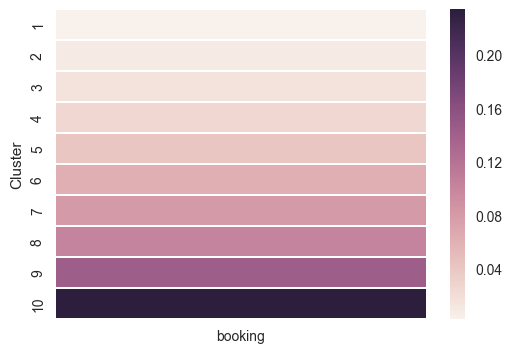

In [17]:
ComparaCluster_Booking =  ComparaCluster_Booking(df_treino)
ComparaCluster_Booking

,Prob_Consumo,fl_ServicoPai,Provisioning,quantidade_renovacoes_prov,idade_cli,Qtd_meses_P_renovacoes,fl_GerenteConta,fl_Dev,FlagChurn,idade_prov,nr_PrecoMensal
Cluster,,,,,,,,,,,
1,0.158722,0.000000,410323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.408207,0.679647,79425,11.376328,53.777337,1.937867,0.000025,0.008045,0.000000,43.746999,25.560531
3,0.539558,1.399926,65182,11.412523,47.465473,4.635292,0.000537,0.017091,0.000061,35.879128,70.986689
4,0.610901,1.834605,52420,10.749523,56.257217,4.147808,0.000725,0.030313,0.331744,32.649886,102.858382
5,0.665375,2.128614,41574,8.114883,47.582357,4.596049,0.001203,0.031823,0.534589,24.440348,116.503170
6,0.717092,2.906603,30729,8.518078,51.272794,5.020722,0.001822,0.047187,1.069966,22.401232,169.033558
7,0.765079,4.506141,18076,7.686048,59.066637,4.785348,0.003817,0.066331,2.028380,20.993563,283.238009
8,0.812621,4.242670,10846,7.843690,61.140584,4.165843,0.007560,0.082796,1.516965,19.377578,308.846557
9,0.851484,5.790456,7230,7.702636,68.341548,4.274783,0.021438,0.115076,2.324481,19.060850,503.043805


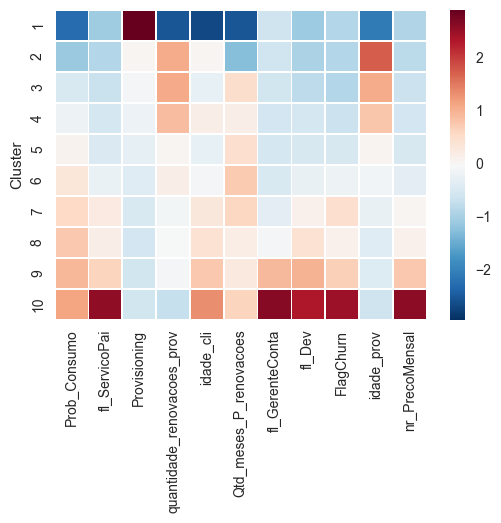

In [18]:
ComparaCluster_DadoCli =  ComparaCluster_DadoCli(df_treino)
ComparaCluster_DadoCli

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cluster,1,2,3,4,5,6,7,8,9,10
Servico_Registro Dominio,0.847769,0.551514,0.543263,0.733880,0.999086,1.506655,2.892454,2.292181,3.394606,9.438805
Servico_Hospedagem,0.907305,1.040919,0.941870,1.141454,1.039424,1.213186,1.361640,1.572285,1.840802,2.737104
Servico_Cloud Server Pro,0.023092,0.348996,0.018287,0.052900,0.041877,0.092226,0.174817,0.308593,0.686030,1.294703
Servico_Email MKT,0.048425,0.228946,0.030637,0.079702,0.103863,0.198314,0.281810,0.359580,0.517981,0.602268
Servico_Licencas - Dedicado,0.004197,0.111590,0.008883,0.012781,0.012460,0.023203,0.039666,0.104831,0.227939,0.424423
Servico_Email,0.041450,0.070268,0.094781,0.116291,0.130971,0.154968,0.179852,0.216578,0.276487,0.406721
Servico_Revenda Hosp.,0.029923,0.061228,0.022813,0.045670,0.041516,0.085489,0.135594,0.153789,0.200830,0.293597
Servico_Servidor Dedicado,0.003687,0.035228,0.008377,0.015624,0.010920,0.012724,0.022129,0.036972,0.080083,0.227769
Servico_Exchange,0.009580,0.015700,0.012549,0.036799,0.043368,0.067884,0.103839,0.149548,0.164039,0.224035
Servico_PABX Virtual,0.015873,0.085817,0.009696,0.017989,0.026868,0.037652,0.085915,0.152591,0.142324,0.216153


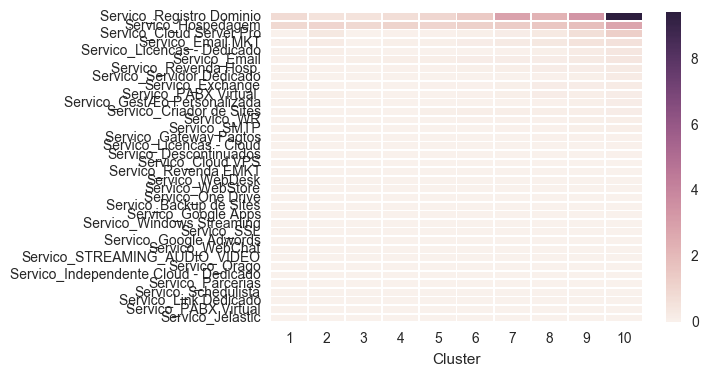

In [19]:
ComparaCluster_DadoProdutos = ComparaCluster_DadoProdutos(df_treino)
ComparaCluster_DadoProdutos

# Aplicando na Base

### Dados do treino

In [20]:
#Churn_Consumo_Recomendacao_18.08.2017
df_base = pd.read_csv('./Churn_Consumo_Recomendacao_dd.mm.yyyy.csv'
                      , error_bad_lines = False
                      , sep=';'
                      , dtype= {7: str}
                      , encoding='latin-1'
                      , header = 0)
df_base['Status'] = ['ativo' if s in ['Ativo', 'Atendido', 'Em ativação',
                                      'Aguardando ativação'] else 'inativo'
                     for s in df_base.Status]
df_base['fl_Dev'] = df_base['fl_Dev'].astype(float,)
df_base = df_base[(df_base.nr_PrecoMensal > '0,00')].copy()
df_base.sort_values(['Instalacao'], ascending= 1 ,inplace=True)
df_base.drop_duplicates(['Provisioning'], keep='last', inplace= True)
col_datas = ['Data_Desativacao', 'Data_Fim', 'Instalacao', 'dt_Reativacao', 'Primeiro_Servico_LW']
converte_datetime(df_base, col_datas)
df_base['Data_Fim_flag'] = [1 if d_fim != datetime(1900,1,1) else 0 for d_fim in df_base.Data_Fim]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_churn'] = df_base[['Data_Fim', 'Data_Desativacao']].min(axis = 1).astype('datetime64[ns]')
df_base['Data_churn'] = [d_fim if ((d_des < d_rea < d_fim) & f_fim & f_des) else d_chu
                              for d_des, d_rea, d_fim, f_fim, f_des, d_chu in 
                              zip(df_base.Data_Desativacao, df_base.dt_Reativacao, 
                                  df_base.Data_Fim, df_base.Data_Fim_flag, 
                                  df_base.Data_Desativacao_flag, df_base.Data_churn)]
df_base['Data_churn_flag'] = [1 if d > datetime(1900, 1, 1) else 0 for d in df_base.Data_churn]
#######################################
df_base = df_base[df_base.Primeiro_Servico_LW >= datetime(1990,1,1)].copy()  #
#######################################
df_base['Primeiro_Servico_LW_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Primeiro_Servico_LW]
df_base['Instalacao_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Instalacao]
df_base['Data_churn_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Data_churn]
df_base['fl_ServicoPai'] = [1 if s in ['SIM', 'Sim', 'sim'] else 0 for s in df_base.fl_ServicoPai]
df_base['fl_GerenteConta'] = [0 if s== 1 else 1 for s in df_base.id_GerenteConta]
df_base['nr_PrecoMensal'] = [x.replace(',', '.') for x in df_base.nr_PrecoMensal]
df_base['nr_PrecoMensal'] = df_base.nr_PrecoMensal.astype(float)
df_base['MesesParaChurn'] = [diff_month(ch, ins) if ch > datetime(1900, 1, 1) else 0
                           for ch, ins in  zip(df_base.Data_churn, df_base.Instalacao)]
df_base['FlagChurn'] = [1 if d!= 0 else 0 for d in df_base.MesesParaChurn]

In [21]:
print(fim_janela_feature)
print(fim_janela_feature+ relativedelta(months=janela_booking))
print(janela_booking)

2017-02-01 00:00:00
2017-05-01 00:00:00
3


### Dados do teste

In [22]:
fim_janela_feature = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-3)
#janela_booking = 1

print(fim_janela_feature)
print(fim_janela_feature+ relativedelta(months=janela_booking))

2017-05-01 00:00:00
2017-08-01 00:00:00


In [23]:
df_atual = ArrumaBase_Consumo(fim_janela_feature, janela_booking, df_base)
if flag_dominio == 0:
    df_atual = df_atual[df_atual['Servico_Registro Dominio'] == 0].copy()

if flag_dominio == 1:
    df_atual = df_atual[df_atual['Servico_Registro Dominio'] != 0].copy()

In [24]:
del df_base

In [25]:
df_atual.cd_ChaveCliente.duplicated().value_counts()

False    363148
Name: cd_ChaveCliente, dtype: int64

In [27]:
df_atual.booking.mean()

0.022409596087545575

In [28]:
df_atual = AplicaModelo_Base(clf, df_treino, df_atual)

,booking
Cluster,
1,0.003018
2,0.013036
3,0.024650
4,0.034374
5,0.051482
6,0.066023
7,0.090759
8,0.130163
9,0.167447


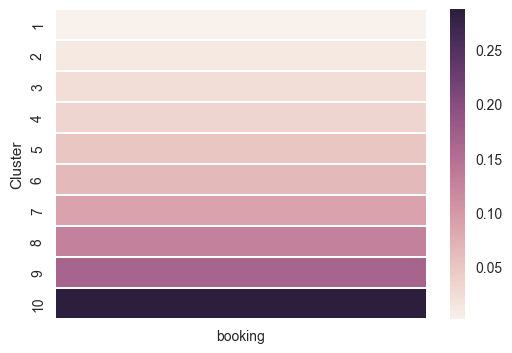

In [31]:
ComparaCluster_Booking =  ComparaCluster_Booking(df_atual)
ComparaCluster_Booking

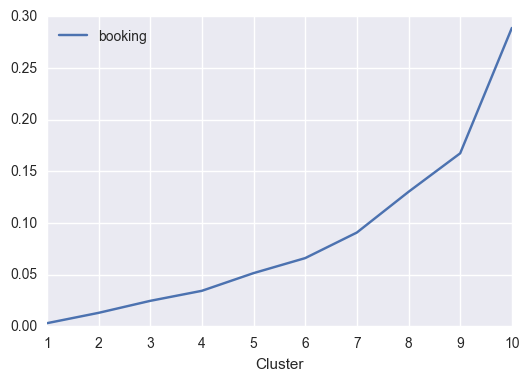

In [35]:
ComparaCluster_Booking.plot()

### Atual

In [32]:
fim_janela_feature = df_base.Instalacao.max()
#janela_booking = 1

print(fim_janela_feature)
print(fim_janela_feature+ relativedelta(months=janela_booking))

2017-08-17 00:00:00
2017-11-17 00:00:00


In [33]:
df_atual = ArrumaBase_Consumo(fim_janela_feature, janela_booking, df_base)
if flag_dominio == 0:
    df_atual = df_atual[df_atual['Servico_Registro Dominio'] == 0].copy()

if flag_dominio == 1:
    df_atual = df_atual[df_atual['Servico_Registro Dominio'] != 0].copy()

In [34]:
df_atual.cd_ChaveCliente.duplicated().value_counts()

False    372227
Name: cd_ChaveCliente, dtype: int64

In [35]:
df_atual.booking.value_counts()

0    372227
Name: booking, dtype: int64

In [36]:
df_atual = AplicaModelo_Base(clf, df_treino, df_atual)

,Provisioning,fl_Dev,fl_GerenteConta,nr_PrecoMensal,FlagChurn,idade_cli,fl_ServicoPai,Qtd_meses_P_renovacoes,Prob_Consumo,quantidade_renovacoes_prov,idade_prov
Cluster,,,,,,,,,,,
1,220485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.305999,0.000000,0.000000
2,37269,0.006493,0.000054,61.800553,0.000080,50.987798,1.359870,3.816557,0.501984,6.550487,43.013631
3,32582,0.022773,0.000215,97.253790,0.180038,49.062951,2.036892,5.454577,0.597446,5.235661,29.245709
4,25125,0.015602,0.000438,100.374201,0.242786,34.727327,2.164736,5.816567,0.650402,4.159954,23.084175
5,22191,0.031544,0.000901,159.930028,0.791672,51.734351,2.976567,5.112612,0.694598,6.105630,27.738403
6,13171,0.057703,0.002278,234.570424,1.393668,63.421973,4.183281,4.792993,0.740562,6.889911,27.356706
7,9306,0.082742,0.005480,391.459549,2.889426,75.556643,6.631098,4.648670,0.785277,7.409618,29.759341
8,5583,0.105857,0.012001,625.759764,4.068064,80.322568,9.682250,4.744298,0.820733,6.354179,24.058493
9,2792,0.130372,0.021848,669.261300,3.585960,76.394862,9.477794,4.833317,0.854797,6.045968,23.356733


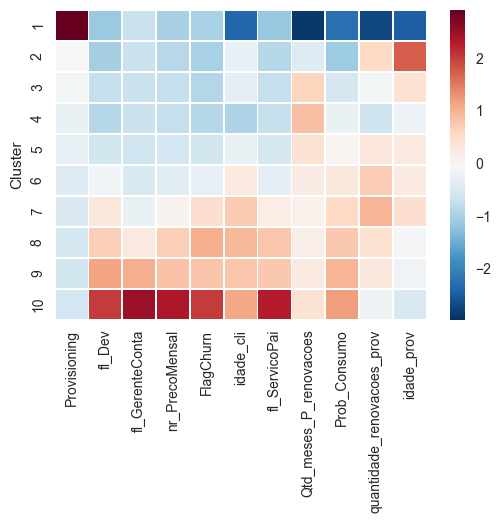

In [37]:
ComparaCluster_DadoCli =  ComparaCluster_DadoCli(df_atual)
ComparaCluster_DadoCli